# Análisis y predicciones de datos reales de los residentes en 2 semanas

Este proyecto analiza datos recopilados durante dos semanas sobre las emociones y comentarios de los residentes de MediaLab. El objetivo principal es explorar cómo varían las emociones a lo largo del tiempo y comprender la relación entre estas emociones y los comentarios proporcionados por los residentes.

### Objetivos del Análisis

El primer objetivo del análisis es estudiar cómo evolucionaron las emociones de los residentes de MediaLab durante las dos semanas de recopilación de datos. A través de un análisis temporal, se busca identificar patrones o tendencias que puedan evidenciar fluctuaciones en los estados emocionales a lo largo del tiempo, proporcionando una visión más profunda de los cambios emocionales diarios.

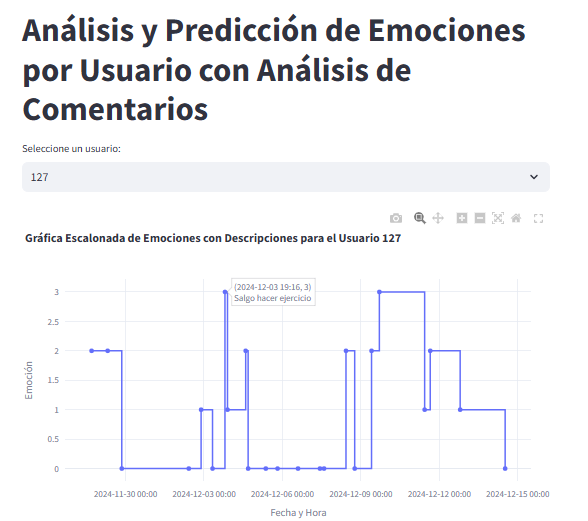


El segundo objetivo es busca predecir emociones futuras utilizando modelos de predicción basados en datos históricos. Estas predicciones permiten estimar cómo podrían evolucionar las emociones en los próximos días, lo que puede ser útil para anticipar necesidades emocionales o mejorar la gestión del grupo en entornos como MediaLab.

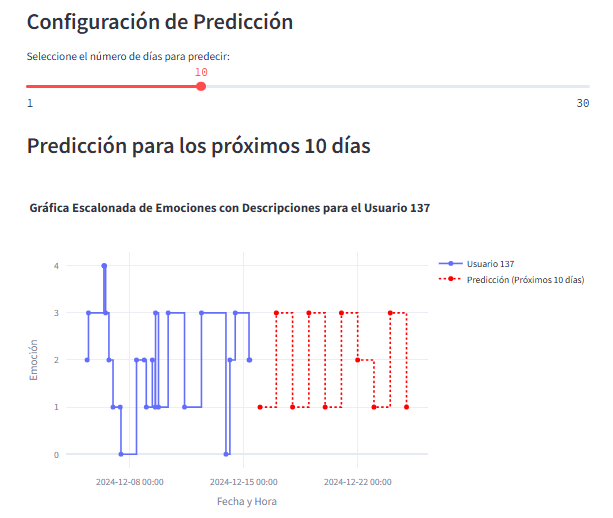

El tercer objetivo se centra en la relación entre los comentarios escritos por los residentes y sus emociones. Este análisis permite explorar qué palabras o frases están más asociadas con cada tipo de emoción registrada, ayudando a entender cómo el contenido textual de los comentarios refleja y complementa los estados emocionales.

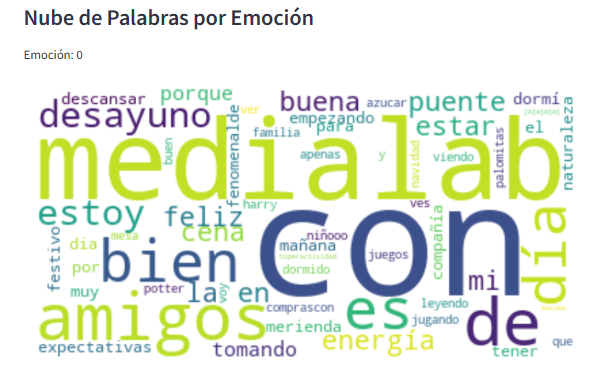

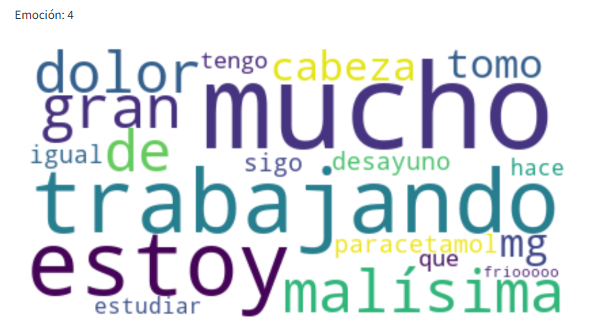


Otro aspecto clave del análisis es la agrupación de comentarios mediante técnicas de clustering. Esto permite identificar similitudes entre los comentarios de los residentes, organizándolos en grupos temáticos o patrones recurrentes que revelen preocupaciones comunes o áreas de interés.



### Resultados Esperados

El análisis permite:
- Comprender cómo varían las emociones en un entorno de convivencia como MediaLab.
- Identificar los temas o preocupaciones principales reflejados en los comentarios.
- Predecir posibles tendencias emocionales para gestionar mejor las dinámicas grupales.

Este enfoque integrador combina técnicas de análisis temporal y textual para proporcionar una visión completa del bienestar y las interacciones de los residentes.

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from statsmodels.tsa.statespace.sarimax import SARIMAX
import plotly.graph_objects as go

# Ruta del archivo local
file_path = "./df_real_descargado.csv"  # Cambia la ruta según tu archivo

# Carga del archivo CSV
@st.cache_data
def cargar_csv_local(ruta):
    try:
        df = pd.read_csv(ruta)
        return df
    except FileNotFoundError:
        st.error(f"No se encontró el archivo en la ruta especificada: {ruta}")
        return pd.DataFrame()

df = cargar_csv_local(file_path)

# Asegurarse de que la columna de fecha esté en formato datetime
if not df.empty and "fecha" in df.columns:
    df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")

# Título de la aplicación
st.title("Análisis y Predicción de Emociones por Usuario con Análisis de Comentarios")

# Selección de usuario
if not df.empty and "id_paciente" in df.columns:
    usuarios_disponibles = df["id_paciente"].unique()
    id_usuario = st.selectbox("Seleccione un usuario:", usuarios_disponibles)

    # Filtrar datos para el usuario seleccionado
    datos_usuario = df[df["id_paciente"] == id_usuario]

    if datos_usuario.empty:
        st.warning("No hay datos disponibles para este usuario.")
    else:
        # Ordenar los datos por fecha
        datos_usuario = datos_usuario.sort_values(by="fecha")

        # Crear gráfica escalonada para datos históricos
        fig = go.Figure()
        fig.add_trace(
            go.Scatter(
                x=datos_usuario["fecha"],
                y=datos_usuario["emocion"],
                mode="lines+markers",
                line_shape="hv",
                name=f"Usuario {id_usuario}",
                hovertext=datos_usuario["comentario"],  # Mostrar comentario en el hover
                hoverinfo="text+x+y"  # Mostrar comentario, fecha y emoción
            )
        )

        # Configuración de diseño
        fig.update_layout(
            title=f"Gráfica Escalonada de Emociones con Descripciones para el Usuario {id_usuario}",
            xaxis_title="Fecha y Hora",
            yaxis_title="Emoción",
            template="plotly_white",
            xaxis=dict(tickformat="%Y-%m-%d %H:%M", showgrid=True),
            yaxis=dict(showgrid=True)
        )

        # Mostrar gráfica histórica
        st.plotly_chart(fig)

        # Selección de cantidad de días para predecir
        st.write("### Configuración de Predicción")
        dias_a_predecir = st.slider("Seleccione el número de días para predecir:", min_value=1, max_value=30, value=10)

        # Predicción
        st.write(f"### Predicción para los próximos {dias_a_predecir} días")
        emociones_diarias = datos_usuario.groupby(datos_usuario["fecha"].dt.date)["emocion"].mean()
        emociones_diarias.index = pd.to_datetime(emociones_diarias.index)

        # Entrenar modelo SARIMAX
        modelo = SARIMAX(emociones_diarias, order=(1, 1, 1), seasonal_order=(0, 1, 1, 7))
        modelo_ajustado = modelo.fit(disp=False)

        # Predicciones futuras
        prediccion = modelo_ajustado.get_forecast(steps=dias_a_predecir)
        fechas_prediccion = pd.date_range(start=emociones_diarias.index[-1] + pd.Timedelta(days=1), periods=dias_a_predecir, freq="D")
        predicciones = pd.DataFrame({
            "fecha": fechas_prediccion,
            "emocion": prediccion.predicted_mean.round().clip(1, 6).astype(int)
        })

        # Añadir predicción como gráfica escalonada independiente
        fig.add_trace(
            go.Scatter(
                x=predicciones["fecha"],
                y=predicciones["emocion"],
                mode="lines+markers",
                line_shape="hv",
                name=f"Predicción (Próximos {dias_a_predecir} días)",
                line=dict(dash="dot", color="red"),
                hovertext=["Predicción"] * dias_a_predecir,  # Texto fijo para predicciones
                hoverinfo="text+x+y"  # Mostrar fecha y emoción
            )
        )

        # Actualizar gráfica con predicción escalonada
        st.plotly_chart(fig)

        # Mostrar tabla de predicciones
        st.write(f"Tabla de Predicciones para los Próximos {dias_a_predecir} Días")
        st.dataframe(predicciones)

# Análisis de comentarios
if not df.empty and "comentario" in df.columns and "emocion" in df.columns:
    df = df.dropna(subset=["comentario"])

    def preprocesar_texto(texto):
        if isinstance(texto, str):
            texto = texto.lower()
            texto = ''.join([c for c in texto if c.isalnum() or c.isspace()])
            return texto
        return ""

    df["comentario"] = df["comentario"].apply(preprocesar_texto)
    df = df[df["comentario"].str.strip() != ""]

    st.write(f"Número de filas después del preprocesamiento: {df.shape[0]}")

    # TF-IDF Vectorization
    tfidf = TfidfVectorizer(max_features=500)
    X = tfidf.fit_transform(df["comentario"]).toarray()

    st.subheader("Relación de Palabras y Emociones")
    vocab = tfidf.get_feature_names_out()
    emocion_promedio = pd.DataFrame(X, columns=vocab).join(df["emocion"])
    emocion_promedio = emocion_promedio.groupby("emocion").mean()

    # Heatmap
    if not emocion_promedio.empty:
        st.write("Heatmap de palabras por emoción:")
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.heatmap(emocion_promedio.T, cmap="coolwarm", annot=False, ax=ax)
        st.pyplot(fig)

    # WordCloud por emociones
    st.subheader("Nube de Palabras por Emoción")
    for emocion in sorted(df["emocion"].unique()):
        st.write(f"Emoción: {emocion}")
        texto = " ".join(df[df["emocion"] == emocion]["comentario"])
        wordcloud = WordCloud(max_words=200, background_color="white").generate(texto)
        fig, ax = plt.subplots()
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.axis("off")
        st.pyplot(fig)

    # Clustering
    st.subheader("Clustering de Comentarios")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    kmeans = KMeans(n_clusters=3, random_state=42).fit(X_pca)
    df["cluster"] = kmeans.labels_

    fig, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap="viridis", s=50)

    # Añadir etiquetas a cada punto del gráfico
    for i, comentario in enumerate(df["comentario"]):
        ax.text(X_pca[i, 0], X_pca[i, 1], comentario[:20], fontsize=8)  # Muestra los primeros 20 caracteres del comentario

    plt.colorbar(scatter)
    st.pyplot(fig)

    # Descargar el resultado final
    csv = df.to_csv(index=False).encode('utf-8')
    st.download_button("Descargar Resultados", csv, "comentarios_clustereados.csv", "text/csv")
else:
    st.error("El archivo no contiene las columnas `comentario` y `emocion`.")
